# Imports

In [86]:
pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [87]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io,transform,img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import math
import time
from datetime import datetime
import shutil
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFont
import torchvision.utils as vutils
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix
import itertools

# Saving cropped images

below is comment and will be removed later because we use GetCropDataset.ipynp for cropping images 

In [88]:
# class CroppedZooplanktonDataset(Dataset):
#     def __init__(self, csv, root_dir, transform=None):
#         self.annotations = pd.read_csv(os.path.join(root_dir, csv))
#         self.root_dir = root_dir
#         self.transform = transform
    
#     def __len__(self):
#         return len(self.annotations)
    
#     def __getitem__(self, index):
#         img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
#         image = Image.open(img_path).convert('RGB')
        
#         # Extract coordinates for area of interest from the CSV columns
#         TL_x = self.annotations.iloc[index, 3]  # Top-left x-coordinate
#         TL_y = self.annotations.iloc[index, 4]  # Top-left y-coordinate
#         BR_x = self.annotations.iloc[index, 5]  # Bottom-right x-coordinate
#         BR_y = self.annotations.iloc[index, 6]  # Bottom-right y-coordinate
                
#         cropped_image = image.crop((TL_x, TL_y, BR_x, BR_y))
        
#         y_label = self.annotations.iloc[index, 9]
#         y_label = 0 if y_label == "marine-snow" else 1
            
#         if self.transform:
#             cropped_image = self.transform(cropped_image)
        
#         return (cropped_image, y_label)

In [89]:
input_folder = '/home/ec2-user/SageMaker/dataset/2022-09-08'
output_folder = '/home/ec2-user/SageMaker/dataset/cropped'

In [90]:
# os.makedirs(output_folder, exist_ok=True)

In [91]:
# dataset = CroppedZooplanktonDataset(csv='result_2022_09_08.csv', root_dir=input_folder)

In [92]:
# for i in range(len(dataset)):
#     cropped_image, _ = dataset[i]  # cropped image
#     image_name = dataset.annotations.iloc[i, 1]  #image name
#     output_path = os.path.join(output_folder, image_name)  #output path
#     cropped_image.save(output_path)

remeber we have saved images without transform so we have to apply transformation in the dataloader

# Dataset and dataloaders

In [93]:
class ZooplanktonDataset(Dataset):
    def __init__(self, csv, cropped_image_folder, transform=None):
        self.annotations = pd.read_csv(csv)
        self.cropped_image_folder = cropped_image_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 1]
        cropped_img_path = os.path.join(self.cropped_image_folder, img_name)
        
        image = Image.open(cropped_img_path)
        
        y_label = self.annotations.iloc[index, 9]
        y_label = 0 if y_label == "marine-snow" else 1
            
        if self.transform:
            image = self.transform(image)
        
        return image, y_label


In [94]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# data_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

dataset = ZooplanktonDataset(csv='dataset/cropped/annotations.csv',cropped_image_folder='dataset/cropped',
                            transform=data_transform)

# Calculate split sizes
dataset_length = len(dataset)
train_size = int(0.8 * dataset_length)
test_size = dataset_length - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size,test_size])

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)

# Models

In [95]:
class Basemodel(nn.Module):
    def __init__(self):
        super(Basemodel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

In [96]:
class Model_v1(nn.Module):
    def __init__(self):
        super(Model_v1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 64 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x


In [97]:
class Model_v2(nn.Module):
    def __init__(self):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))  
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x


# Loss curve 

In [98]:
class LossCurve:
    def __init__(self):
        self

    def PlotCurve(loss_values,epochs):
        plt.plot(range(epochs), loss_values, 'blue')
        plt.title('Loss decay')
        plt.xlabel('number of epochs')
        plt.ylabel('Loss')
        plt.show()

# Training Loop

In [99]:
class Trainer():
    def __init__(self, model, loss_criterion,
                 train_data_loader, test_data_loader,
                 optimizer, epochs, with_cuda,
                 use_scheduler, scheduler, save_dir,tensorboard_dir, lr=0.001,print_freq=1):
        self.device = torch.device("cuda:0" if with_cuda else "cpu")
        self.model = model
        self.loss_criterion = loss_criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.with_cuda = with_cuda
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self.lr = lr
        self.save_dir = save_dir
        self.tensorboard_dir = tensorboard_dir
        self.use_scheduler = use_scheduler
        self.scheduler = scheduler
        self.step = 0
        self.print_freq = print_freq
        self.start_time = datetime.now().strftime('%b-%d_%H-%M')
        self.save_freq = 1
        self.accuracy = 0
        if not os.path.exists(self.tensorboard_dir):
            os.makedirs(self.tensorboard_dir)
        self.writer = SummaryWriter(log_dir=self.tensorboard_dir)
        
    def _train_epoch(self):
        loss_values = []
        
        for epoch in range(self.epochs):
            running_loss = 0
            last_step = self.step - 1
            last_time = time.time()
            batch_counter = 0
            accuracy=0
            loop = tqdm(enumerate(self.train_data_loader), total=len(self.train_data_loader), leave=True)
            for batch_idx, (images, labels) in loop:
                if self.with_cuda:
                    images, labels = images.to(self.device), labels.to (self.device)
                model.train()
                batch_counter += 1
                # forward pass
                outputs = self.model(images)
                # finding loss
                loss = self.loss_criterion(outputs, labels)
                # backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if self.use_scheduler:
                    self.scheduler.step()

                running_loss += loss.item()
                # evaluation of model on test data
                if batch_counter % 10 == 0 or batch_counter == len(self.train_data_loader):
                    accuracy = self._valid_epoch(model, epoch, self.test_data_loader)
                
                is_best = False
                if accuracy > self.accuracy:
                    is_best = True
                self.accuracy = accuracy
                
                if self.step % self.print_freq == self.print_freq - 1:
                    used_time = time.time() - last_time
                    step_num = self.step - last_step
                    speed = self.train_data_loader.batch_size * \
                        step_num / used_time
                    batch_loss = loss.item()
                    loop.set_description(f"Epoch[{epoch + 1}/{self.epochs}]")
                    loop.set_postfix(
                    lr=self.scheduler.get_last_lr(),
                    batch_loss=batch_loss,
                    global_loss = running_loss,
                    speed=speed,
                    accuracy = self.accuracy,
                    device = self.device
                    )
                    global_loss = 0.0
                    last_step = self.step
                    last_time = time.time()
                self.step += 1

            if epoch % self.save_freq == 0:
                self._save_checkpoint(epoch, is_best)
            
            self.writer.add_scalar('Loss', running_loss / len(self.train_data_loader), global_step=self.step)
            loss_values.append(running_loss / len(self.train_data_loader))
            
        # Plotting Loss Curve
        LossCurve.PlotCurve(loss_values, self.epochs)
        
        #logging images to Tensorboard
        self.log_images_after_training()
        
        #closing SummaryWriter Object
        self.writer.close()
        
    def _valid_epoch(self, model, epoch, test_loader):
        model.eval()
        with torch.no_grad():
            correct_samples = 0
            total_samples = 0
            for images, labels in test_loader:
                if self.with_cuda:
                    images, labels = images.to(self.device), labels.to (self.device)
                pred_ratio = model(images)
                _, pred_labels = torch.max(pred_ratio, 1)
                total_samples += labels.size(0)
                correct_samples += (pred_labels == labels).sum().item()
            accuracy = (correct_samples / total_samples) * 100
            self.writer.add_scalar('Accuracy', accuracy, global_step=epoch)
            return accuracy
    
    def _save_checkpoint(self, epoch, is_best):
        arch = type(self.model).__name__
        state = {
            'epoch': epoch,
            'arch': arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'accuracy': self.accuracy,
            'step': self.step + 1,
            'start_time': self.start_time}
        filename = os.path.join(
            self.save_dir+
            'checkpoint_{}_epoch{:02d}_acc_{:.5f}.pth.tar'.format(
                arch,
                epoch, 
                self.accuracy))
        print("Saving checkpoint: {} ...".format(filename))
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(
                filename, os.path.join(self.save_dir, 'model_best.pth.tar'))
        return filename

    def log_images_after_training(self):
        checkpoint = torch.load("/home/ec2-user/SageMaker/checkpoints/cropped/model_best.pth.tar")
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()
        images = []
        true_labels = []
        predicted_labels = []

        for batch_images, batch_labels in self.test_data_loader:
            with torch.no_grad():
                if self.with_cuda:
                    batch_images, batch_labels = batch_images.to(self.device), batch_labels.to(self.device)

                # Forward pass to obtain predicted labels for each item in the batch
                batch_outputs = self.model(batch_images)
                batch_predicted_labels = torch.argmax(batch_outputs, dim=1)
            # Iterate over each item in the batch
            for i in range(batch_images.size(0)):
                image = vutils.make_grid(batch_images[i], nrow=1, padding=10, normalize=True) 
                true_label = batch_labels[i]
                predicted_label = batch_predicted_labels[i]

                images.append(image)
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

        for i in range(len(images)):
            image = images[i]
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]

            # Set the image name as the predicted and true labels
            image_name = f"Image-{i}-True-{true_label}-Predicted-{predicted_label}"

            # Log the image on TensorBoard with the image name
            self.writer.add_image(image_name, image.cpu(), global_step=i)

        #creating confusion matrix
        true_labels = torch.tensor(true_labels)
        predicted_labels = torch.tensor(predicted_labels)

        cm = confusion_matrix(true_labels, predicted_labels)

        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()

        # Set the axis labels and ticks
        class_names = ['Zooplankton', 'Marine-Snow']
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        # Add labels to each cell of the confusion matrix
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        # Save the confusion matrix figure to TensorBoard
        self.writer.add_figure('Confusion Matrix', fig)



# Hyperparameters

In [100]:
    #model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Model_v1()
    model.to(device)
    parameters = filter(lambda p: p.requires_grad, model.parameters())
   # optimizer 
    optimizer = optim.Adam(
        params=parameters,
        lr=0.001,
        betas=(0.8, 0.999),
        eps=1e-8,
        weight_decay=3e-7)
    #scheduler
    lr_warm_up_num = 100
    cr = 1.0 / math.log(lr_warm_up_num)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda ee: cr * math.log(ee + 1)
        if ee < lr_warm_up_num else 1)
    #  loss, metrics
    loss_criterion = torch.nn.CrossEntropyLoss()
    #creating object for tensorboard_dir
    tensorboard_dir = '/home/ec2-user/SageMaker/runs/'


# Trainer Object

In [101]:
   trainer = Trainer(
        model, loss_criterion,
        train_data_loader=train_loader,
        test_data_loader=test_loader,
        optimizer=optimizer,
        epochs=10,
        with_cuda=True,
        use_scheduler=True,
        scheduler=scheduler,
        save_dir='/home/ec2-user/SageMaker/checkpoints/cropped/',
        tensorboard_dir=tensorboard_dir,
        lr=0.001)
 

Epoch[1/10]: 100%|██████████| 47/47 [00:33<00:00,  1.41it/s, accuracy=91.1, batch_loss=0.0942, device=cuda:0, global_loss=16.5, lr=[0.0008406206186877935], speed=7.69]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch00_acc_91.10512.pth.tar ...


Epoch[2/10]: 100%|██████████| 47/47 [00:33<00:00,  1.42it/s, accuracy=90.6, batch_loss=1.6, device=cuda:0, global_loss=12.6, lr=[0.0009888618026444237], speed=9.03]  


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch01_acc_90.56604.pth.tar ...


Epoch[3/10]: 100%|██████████| 47/47 [00:33<00:00,  1.40it/s, accuracy=90.3, batch_loss=0.142, device=cuda:0, global_loss=10.3, lr=[0.001], speed=8.79]             


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch02_acc_90.29650.pth.tar ...


Epoch[4/10]: 100%|██████████| 47/47 [00:28<00:00,  1.63it/s, accuracy=91.4, batch_loss=0.515, device=cuda:0, global_loss=7.89, lr=[0.001], speed=8.66] 


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch03_acc_91.37466.pth.tar ...


Epoch[5/10]: 100%|██████████| 47/47 [00:24<00:00,  1.92it/s, accuracy=94.1, batch_loss=0.0472, device=cuda:0, global_loss=6.7, lr=[0.001], speed=12.6] 


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch04_acc_94.07008.pth.tar ...


Epoch[6/10]: 100%|██████████| 47/47 [00:23<00:00,  1.98it/s, accuracy=94.6, batch_loss=0.00272, device=cuda:0, global_loss=4.28, lr=[0.001], speed=12.4]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch05_acc_94.60916.pth.tar ...


Epoch[7/10]: 100%|██████████| 47/47 [00:23<00:00,  1.96it/s, accuracy=93.8, batch_loss=0.0138, device=cuda:0, global_loss=4.03, lr=[0.001], speed=12.4]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch06_acc_93.80054.pth.tar ...


Epoch[8/10]: 100%|██████████| 47/47 [00:24<00:00,  1.94it/s, accuracy=96, batch_loss=0.0436, device=cuda:0, global_loss=2.78, lr=[0.001], speed=12.4]     


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch07_acc_95.95687.pth.tar ...


Epoch[9/10]: 100%|██████████| 47/47 [00:23<00:00,  1.97it/s, accuracy=94.1, batch_loss=0.0526, device=cuda:0, global_loss=2.3, lr=[0.001], speed=12.7] 


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch08_acc_94.07008.pth.tar ...


Epoch[10/10]: 100%|██████████| 47/47 [00:23<00:00,  1.98it/s, accuracy=96, batch_loss=0.124, device=cuda:0, global_loss=2.01, lr=[0.001], speed=12.1]     


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/cropped/checkpoint_Model_v1_epoch09_acc_95.95687.pth.tar ...


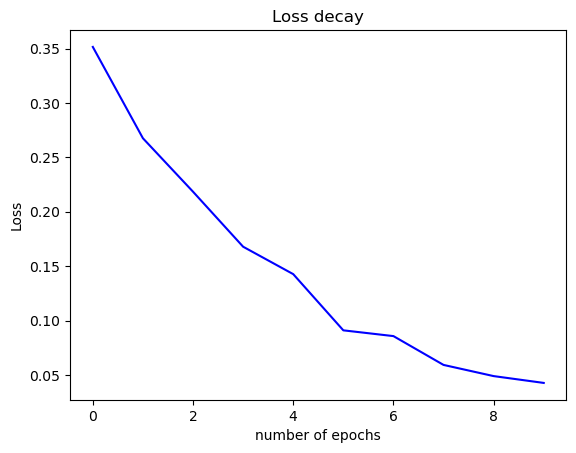

In [102]:
trainer._train_epoch()